### Imports:

In [1]:
from os import listdir
from importlib import reload
import numpy as np
import pyxdf
import mne
from utils import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score

### Constants

In [2]:
path = 'C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm/'
plot = False

### Read xdf-files for specified subject

In [3]:
# List files in folder:
files = [f for f in listdir(path)]

# Load all recorded EEG files for one subject
for count in range(len(files)):
    fname = path + '/' + files[count]
    print(f'Reading xdf file {fname}...')

    streams, header = pyxdf.load_xdf(fname)


    # Split the streams:
    eeg_stream, marker_stream = split_streams(streams)

    eeg = eeg_stream['time_series'].T
    eeg *= 1e-6 # Convert to volts.
    assert eeg.shape[0] == 65
    eeg_ts = eeg_stream['time_stamps']

    markers = marker_stream['time_series']
    # Convert list of list of strings to list of strings:
    markers = [''.join(element) for element in markers]

    # Convert marker strings to integers:
    classes = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']
    classes_map = [1,1,1,1,2,2,2,2]# [1, 2, 1, 2, 1, 2, 1, 2]  #[1, 2, 3, 4, 5, 6, 7, 8]
    timings = ['Start', 'Cue', 'Break']
    timings_map = [11, 12, 13]
    responses = ['c c 0', 'c c 1', 'c r 0', 'c r 1', 'c l 0', 'c l 1', 'c b 0', 'c b 1', 'c t 0', 'c t 1']
    responses_map = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

    concat_codes = classes + timings + responses
    concat_mappings = classes_map + timings_map + responses_map

    coded_markers = markers.copy()

    for i,marker in enumerate(markers):
        for j,code in enumerate(concat_codes):
            if code in marker:
                coded_markers[i] = concat_mappings[j]

    markers_ts = marker_stream['time_stamps']

    # Make Nan array with len(eeg)
    aligned_markers = np.zeros(eeg_ts.shape)

    # Place markers string at the align array where first time markers_ts <= eeg_ts:
    for i,marker in enumerate(coded_markers):
        ts = markers_ts[i]
        idx = np.where(ts <= eeg_ts)[0][0]
        aligned_markers[idx] = marker


    # Replace last row (unused Brainproduct markers) with the aligned recorded markers:
    eeg[64,:] = aligned_markers

    fs = float(eeg_stream['info']['nominal_srate'][0])

    # Extract channel names:
    chn_names = [eeg_stream['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(64)]
    chn_names.append('Markers')
    chn_labels = ['eeg' for i in range(64)]
    chn_labels[16] = 'eog'
    chn_labels[21] = 'eog'
    chn_labels[40] = 'eog'
    chn_labels.append('misc')

    if count == 0:
        global_eeg = eeg
    else:
        global_eeg = np.concatenate((global_eeg, eeg), axis=1)



eeg = global_eeg
print('Done.')

Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-001_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-002_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-003_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-004_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-005_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-006_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-007_eeg.xdf...
Reading xdf file C:/Users/peter/Google Drive/measurements/eeg/A04/paradigm//sub-A04_ses-S001_task-paradigm_run-008_eeg

### Put extracted data into mne structure

In [4]:
info = mne.create_info(chn_names, fs, chn_labels)

raw = mne.io.RawArray(eeg, info)
raw.set_montage('standard_1005')
if plot:
    raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
             remove_dc=False, title='Raw')

Creating RawArray with float64 data, n_channels=65, n_times=787344
    Range : 0 ... 787343 =      0.000 ...  3936.715 secs
Ready.


### Filter with HP at 0.4Hz and BS at 50 Hz

In [5]:
raw_highpass = raw.copy().filter(l_freq=0.4, h_freq=None, picks=['eeg'], method='iir')
if plot:
    raw_highpass.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
                      remove_dc=False, title='Highpass filtered')
    plot_spectrum(raw_highpass)

raw_notch = raw_highpass.copy().notch_filter(freqs=[50], picks=['eeg'])
if plot:
    raw_notch.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False, title='Notch filtered')
    plot_spectrum(raw_notch)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.40 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



### Interpolate bad channels:

In [6]:
# TODO: check function --> need to mark them first
raw_interp = raw_notch.copy().interpolate_bads(reset_bads=False)

C:\Users\peter\AppData\Local\Temp\ipykernel_20940\3050508301.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_interp = raw_notch.copy().interpolate_bads(reset_bads=False)


### Correct eye artifacts:

In [7]:
# TODO

### CAR:

In [8]:
raw_avg_ref = raw_interp.copy().set_eeg_reference(ref_channels='average')
if plot:
    raw_avg_ref.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False, title='CAR Referenced')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### HEAR model:

In [9]:
# TODO?

### LP at 3.0Hz

In [10]:
raw_lp = raw_avg_ref.copy().filter(l_freq=None, h_freq=3.0, picks=['eeg'], method='iir')

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 3.00 Hz: -6.02 dB



### Extract epochs before resampling (otherwise markers may get lost) and reject bad trials:

In [11]:
events = mne.find_events(raw_lp, stim_channel='Markers')

epochs = mne.Epochs(raw_lp, events, event_id=classes_map, tmin=1, tmax=6, preload=True, baseline=None, reject=dict(eeg=100e-6)) #, baseline=(1,2))

print(epochs)

if plot:
    epochs.plot(n_epochs=2)

2882 events found
Event IDs: [ 1  2 11 12 13 21 22 23 24 25 26 27 28 29 30]
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 360 events and 1001 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'PO9', 'AF7', 'AF3', 'AF4', 'AF8', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'CP6', 'AF7', 'AF3', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F4', 'AF7', 'AF3', 'AF4', 'F5', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp

### Resample to 10 Hz:

In [12]:
epochs_resampled = epochs.copy().resample(10)
print('Preprocessing finished.')

Preprocessing finished.


### Implementing cue-aligned (better according to Reinmar paper)

### Distance decoding:

2882 events found
Event IDs: [ 1  2 11 12 13 21 22 23 24 25 26 27 28 29 30]
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 360 events and 1001 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'PO9', 'AF7', 'AF3', 'AF4', 'AF8', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'CP6', 'AF7', 'AF3', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F4', 'AF7', 'AF3', 'AF4', 'F5', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp

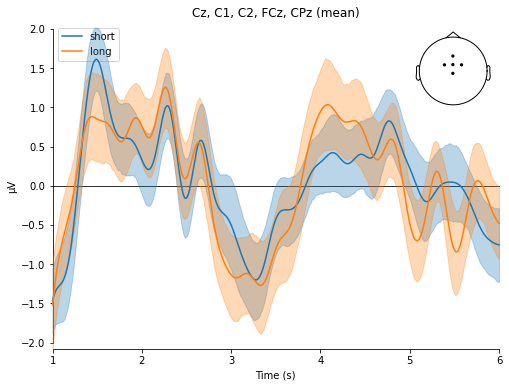

<Figure size 432x288 with 0 Axes>

In [13]:
events = mne.find_events(raw_lp, stim_channel='Markers')
event_dict = {'short': 1, 'long': 2, 'short': 1, 'long': 2, 'short':1, 'long':2, 'short':1, 'long':2}

epochs_long_short = mne.Epochs(raw_lp, events, event_id=event_dict, tmin=1, tmax=6, preload=True, baseline=None, reject=dict(eeg=100e-6))



short = epochs_long_short['short'].average()

long = epochs_long_short['long'].average()

#evokeds = dict(short=short, long=long)
#mne.viz.plot_compare_evokeds(evokeds, picks='POz')

evokeds2 = dict(short=list(epochs_long_short['short'].iter_evoked()),
                long=list(epochs_long_short['long'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds2, combine='mean', picks=['Cz', 'C1', 'C2', 'FCz', 'CPz'], show_sensors='upper right')
plt.savefig('distance_grand_averages.pdf')

#['Pz', 'POz', 'PO3', 'PO4', 'P2', 'P1', 'P2', 'Oz', 'O1', 'O2']

epochs_long_short = epochs_long_short.copy().resample(10)

[1 2 1 2 1 2 1 1 1 2 1 2 2 1 1 2 2 1 1 2 1 2 2 2 1 1 2 2 1 2 1 1 1 1 1 2 2
 1 2 2 2 2 1 1 1 1 2 1 2 1 2 1 2 2 2 2 1 1 1 2 1 1 1 1 2 1 2 1 1 2 2 1 1 2
 2 1 1 1 2 2 2 2 2 2 2 1 1 2 1 1 2 1 1 1 2 1 2 1 2 1 2 2 1 1 1 2 2 1 2 1 1
 1 1 1 2 2 1 2 1 1 2 1 2 2 2 1 2 1 2 1 2 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 1 1
 2 2 2 1 2 2 1 2 1 2 1 1 1 2 2 1 2 1 1 2 2 1 1 2 1 1 1 2 2 1 1 1 1 2 2 2 1
 2 2 1 2 1 2 2 1 1 1 1 2 2 1 2 1 2 2 2 1 1 1 1 1 2 1]
[1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0
 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0
 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1
 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1
 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1
 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1]


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(


0


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

10


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

20


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

30


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

40


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

Done


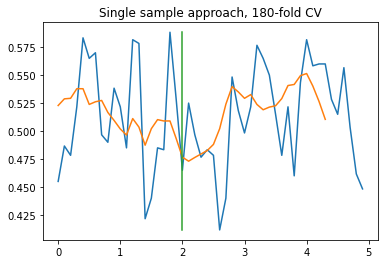

In [14]:
X = []
y = []
for i,epoch in enumerate(epochs_long_short):
    #print(epoch.shape)
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch[:61,:])
    y.append(list(epochs_long_short[i].event_id.values())[0])

X = np.array(X)
y = np.array(y)

print(y)

for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1

print(y)


# Split training and test set:

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])):
    x = X[:,:,idx]
    # Reshape X to 2d array:
    #nsamples, nx, ny = x.shape
    #x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))

    scores = cross_val_score(clf, x, y, cv=100)
    cv_scores.append(scores.mean())

    if idx % 10 == 0:
        print(idx)

print('Done')

t = np.arange(len(acc))
t = t/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[:-window+1], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.title('Single sample approach, 180-fold CV')
plt.savefig('distance_acc_single.pdf')

0
(211, 61, 5)


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

10
(211, 61, 5)


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

20
(211, 61, 5)


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

30
(211, 61, 5)


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

40
(211, 61, 5)


C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(
C:\Users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 97 members, which is less than n

Done


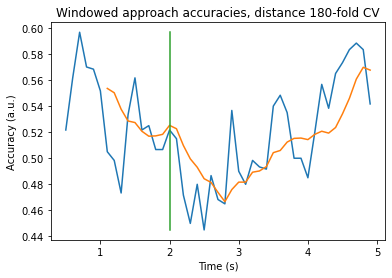

In [15]:
# 5 point LDA
X = []
y = []
for i,epoch in enumerate(epochs_long_short):
    #print(epoch.shape)
    # Deleting Marker channel:
    # Deleting EOG channels:
    epoch = np.delete(epoch, 40, 0)
    epoch = np.delete(epoch, 21, 0)
    epoch = np.delete(epoch, 16, 0)
    X.append(epoch[:61,:])
    y.append(list(epochs_long_short[i].event_id.values())[0])

for i,label in enumerate(y):
    if label % 2 == 0:
        y[i] = 0
    else:
        y[i] = 1


X = np.array(X)
y = np.array(y)


# Split training and test set:

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
acc = []
cv_scores = []
for idx in range(len(X[0,0])-5):
    x = X[:,:,idx:idx+5]
    if idx % 10 == 0:
        print(idx)
        print(x.shape)
    # Reshape X to 2d array:
    nsamples, nx, ny = x.shape
    x = x.reshape((nsamples,nx*ny))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(clf.score(X_test, y_test))

    scores = cross_val_score(clf, x, y, cv=100)
    cv_scores.append(scores.mean())



print('Done')
#print(acc)

t = np.arange(len(acc))
t = t/10 + 5/10
#plt.plot(t, acc)

plt.plot(t, cv_scores)

window = 7

ma = np.convolve(cv_scores, np.ones(window), 'valid') / window

plt.plot(t[window-1:], ma)
plt.plot([2,2], [min(cv_scores), max(cv_scores)])
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (a.u.)')
plt.title('Windowed approach accuracies, distance 180-fold CV')
plt.savefig('distance_acc_5point.pdf')